In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Disable GPU

import jax
import jax.numpy as jnp
import jax.tree_util as jtu
from jax.flatten_util import ravel_pytree

import optax
# import jaxopt

import matplotlib.pyplot as plt

from gpax.core import Parameter, set_default_jitter, set_positive_bijector, get_default_jitter, get_positive_bijector
from gpax.models import ExactGPRegression, SparseGPRegression, LatentGPHeinonen, LatentGPDeltaInducing, LatentGPPlagemann
from gpax.kernels import RBF, Gibbs
from gpax.means import Scalar, Average
from gpax.likelihoods import Gaussian, Heteroscedastic
from gpax.utils import train_fn, DataScaler, add_to_diagonal
from gpax.plotting import plot_posterior
from scipy.io import loadmat, savemat
from sklearn.preprocessing import MinMaxScaler

import tensorflow_probability.substrates.jax as tfp
tfb = tfp.bijectors

import regdata as rd
from tqdm import trange

import pprint
pp = pprint.PrettyPrinter(depth=4)

is_parameter = lambda x: isinstance(x, Parameter)
set_positive_bijector(tfb.Exp())
print(get_default_jitter())

def assert_same_pytree(tree1, tree2):
    assert jtu.tree_structure(tree1) == jtu.tree_structure(tree2)
    assert jnp.all(ravel_pytree(tree1)[0] == ravel_pytree(tree2)[0])

jax.config.update("jax_enable_x64", True)
jax.__version__

1e-06


'0.3.25'

In [2]:
X_, y_, _ = rd.MotorcycleHelmet().get_data()
idx = jnp.argsort(X_[:, 0])
X_ = X_[idx]
y_ = y_[idx]

scaler = DataScaler(X_, y_)
X, y = scaler.transform(X_, y_)

(94, 1)
loss: 1065.048512121258 (l=0.06786186023563023, s=0.1039097487661219, o=0.036014294216000144)
loss: 7471.377043572952 (l=0.17725609001613302, s=0.41791817988779, o=0.014967279692831082)
loss: 857.8399608475422 (l=0.13576382724742786, s=0.39143022513013737, o=0.03982089725369286)
loss: 863.3099635576259 (l=0.2130662100430331, s=0.26279886087587456, o=0.05379431852593059)
loss: 103.19984863848666 (l=0.04136112383122964, s=0.2699754286034548, o=0.08723162632092947)
loss: 72.93309663134167 (l=0.059098687417668605, s=0.28106565994354915, o=0.09544619180450155)
loss: 152.14090936699301 (l=0.08684005447886009, s=0.29733906786795694, o=0.07586471890684075)
loss: 1762.5614328398078 (l=0.06587508279631615, s=0.11103736051039004, o=0.028391104052897617)
loss: 4125.236184203476 (l=0.06954030028104767, s=0.18968611550655884, o=0.01882775545442687)
loss: 9708.747165230534 (l=0.21321677685365972, s=0.4837105641602375, o=0.014204333485727156)
initial loss: 72.93309663141957


100%|██████████| 5000/5000 [00:09<00:00, 529.16it/s]


[DeviceArray(-61.72726082, dtype=float64),
 DeviceArray(-61.73814005, dtype=float64),
 DeviceArray(-61.74608493, dtype=float64),
 DeviceArray(-61.75165928, dtype=float64),
 DeviceArray(-61.75429669, dtype=float64),
 DeviceArray(-61.75429669, dtype=float64),
 DeviceArray(-61.76467729, dtype=float64),
 DeviceArray(-61.7722957, dtype=float64),
 DeviceArray(-61.77645834, dtype=float64),
 DeviceArray(-61.77645834, dtype=float64)]

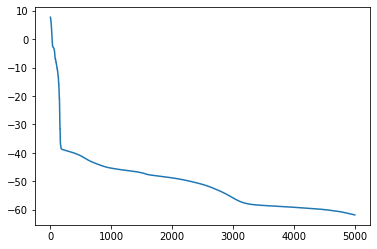

In [16]:
latent_model = LatentGPHeinonen
X_inducing = X

# latent_model = LatentGPDeltaInducing
# X_inducing = jnp.linspace(0, 1, 10).reshape(-1, 1)
# latent_model = LatentGPPlagemann
# X_inducing = X[::10]


print(X_inducing.shape)

def get_model():
    ell_model = latent_model(X_inducing, RBF(X_inducing, 0.3, 0.5).trainable(True), vmap=True)
    sigma_model = latent_model(X_inducing, RBF(X_inducing, 0.3, 0.5).trainable(True), vmap=False)
    likelihood_model = latent_model(X_inducing, RBF(X_inducing, 0.3, 0.5).trainable(True), vmap=False)

    kernel = Gibbs(X_inducing, ell_model, sigma_model, flex_ell=True, flex_sigma=True)
    likelihood = Heteroscedastic(likelihood_model)
    return ExactGPRegression(kernel, likelihood, Average(), X_inducing=X_inducing)

optimizer = optax.adam(learning_rate=0.001)
n_iters = 5000

def loss_fn(raw_params):
    gp.set_raw_parameters(raw_params)
    return -gp.log_probability(X, y)

value_fn = jax.jit(loss_fn)

# Find best initial parameters
best_init_loss = jnp.inf
initial_seed = 50
for i in range(initial_seed, initial_seed+10):
    # l,s,o  = get_positive_bijector()(jax.random.normal(jax.random.PRNGKey(i), (3,)))
    l = jax.random.uniform(jax.random.PRNGKey(i), minval=0.03, maxval=0.3)
    s = jax.random.uniform(jax.random.PRNGKey(i+100), minval=0.1, maxval=0.5)
    o = jax.random.uniform(jax.random.PRNGKey(i+200), minval=0.01, maxval=0.1)
    gp = get_model()
    gp.initialize(jax.random.PRNGKey(i+300))
    gp.kernel.ell_model.reverse_init(l)
    gp.kernel.sigma_model.reverse_init(s)
    gp.likelihood.latent_model.reverse_init(o)
    raw_params = gp.get_raw_parameters()
    init_loss = value_fn(gp.get_raw_parameters())
    print(f"loss: {init_loss} (l={l}, s={s}, o={o})")
    if init_loss < best_init_loss:
        best_init_loss = init_loss
        init_raw_params = raw_params

# print(init_raw_params)
gp.set_raw_parameters(init_raw_params)
#######################

print(f"initial loss: {loss_fn(gp.get_raw_parameters())}")

# Manual
grad_fn = jax.jit(jax.grad(loss_fn))

result = {"loss_history": [jnp.inf], "raw_params": None}

step = jnp.array(1e-5)
steps = []
grads = grad_fn(raw_params)
for iter in trange(n_iters):
    old_params = raw_params
    raw_params = jtu.tree_map(lambda x, g: x - step * g, raw_params, grads)
    loss = value_fn(raw_params)
    if loss >= result["loss_history"][-1]:
        raw_params = old_params
        step *= 0.7
        result["loss_history"].append(result["loss_history"][-1])
    else:
        step *= 1.1
        grads = grad_fn(raw_params)
        result["loss_history"].append(loss)
    steps.append(step)

result["raw_params"] = raw_params

result["loss_history"].pop(0)


# Automatic

# gp.X_inducing.trainable(False)
# result = train_fn(loss_fn, init_raw_params=init_raw_params, optimizer=optimizer, n_iters=n_iters)

plt.plot(result["loss_history"]);
result["loss_history"][-10:]

In [17]:
# wl_ell = result["raw_params"]['kernel']['ell_gp']['latent'].reshape(-1,1)
# wl_sigma  = result["raw_params"]['kernel']['sigma_gp']['latent'].reshape(-1,1)
# wl_omega = result["raw_params"]['likelihood']['latent_gp']['latent'].reshape(-1,1)

# savemat('wdt_wl.mat', {"wl": {'wl_ell': wl_ell, 'wl_sigma': wl_sigma, 'wl_omega': wl_omega}})

Final loss: -61.7764583425263


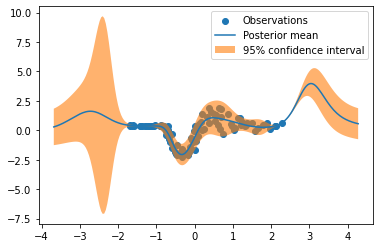

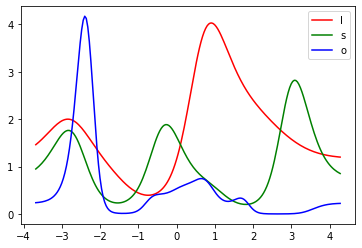

In [18]:
span = 0.5
X_test = jnp.linspace(0-span, 1+span, 200).reshape(-1, 1)
# idx = jnp.nanargmin(result["loss_history"])
# print(f"Best loss: {result['loss_history'][idx]} (iter {idx})")
# best_raw_params = jtu.tree_map(lambda x: x[idx-1], result["raw_params_history"])

best_raw_params = result["raw_params"]


gp.set_raw_parameters(best_raw_params)
print(f"Final loss: {loss_fn(gp.get_raw_parameters())}")
trained_X_inducing = gp.X_inducing()
pred_mean, pred_cov = gp.predict(X, y, X_test, include_noise=False)
pred_ell = gp.kernel.ell_model(trained_X_inducing)(X_test)
pred_sigma = gp.kernel.sigma_model(trained_X_inducing)(X_test)
pred_omega = gp.likelihood.latent_model(trained_X_inducing)(X_test)
pred_cov = add_to_diagonal(pred_cov, pred_omega**2, 0.0)

(X_, X_test_, X_inducing_, trained_X_inducing_), (pred_mean_, y_), pred_ell_, pred_sigma_, pred_omega_ = scaler.inverse_transform((X, X_test, X_inducing, trained_X_inducing), (pred_mean, y), pred_ell, pred_sigma, pred_omega)
pred_cov_ = pred_cov * scaler.y_scale**2

ax = plot_posterior(X_, y_, X_test_, pred_mean_, pred_cov_, ax=None, alpha=0.6);
ax.legend(bbox_to_anchor=(1,1));
# for x in X_inducing_:
#     ax.axvline(x, color="k", alpha=0.3)

# for x in trained_X_inducing_:
#     ax.axvline(x, color="r", alpha=0.3)


plt.figure();
plt.plot(X_test_, pred_ell_, label='l', color='r')
plt.plot(X_test_, pred_sigma_, label='s', color='g')
plt.plot(X_test_, pred_omega_, label='o', color='b');
plt.legend();

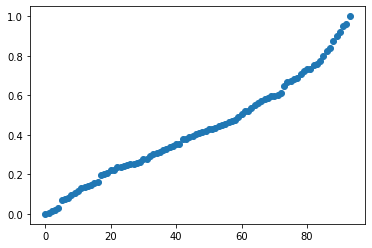

In [6]:
plt.scatter(range(len(trained_X_inducing)), trained_X_inducing);